Outline\
    - Outlier Analysis\
    -Forecasting horizon explained\
    -Time series cross validation\
    -Lag features\
    -Predicting the future

PJM Hourly Energy Consumption Data i sused for the analysis. PJM energy is used to the part of the eastern interconnection grid operating an electrical transmission system serving all or parts of Delaware, Illinois, 
Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

Lag features are used in time series analysis to capture the temporal dependencies and patterns within data by incorporating past values of a variable as features in the current time point, allowing models to learn how previous observations influence future values and ultimately improving the accuracy of predictions by accounting for the time-based relationships in the data. 
When incorporated into machine learning models, lagged features can significantly enhance the accuracy of predictions, especially in scenarios where past data strongly influences future outcomes. 

In [302]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [304]:
import xgboost as xgb

In [350]:
# load data for hourly energy consumptions
df = pd.read_csv('PJME_hourly.csv')
df = df.set_index('Datetime')
# Cast as datetime
df.index = pd.to_datetime(df.index)
df = df.sort_values(by=['Datetime'])

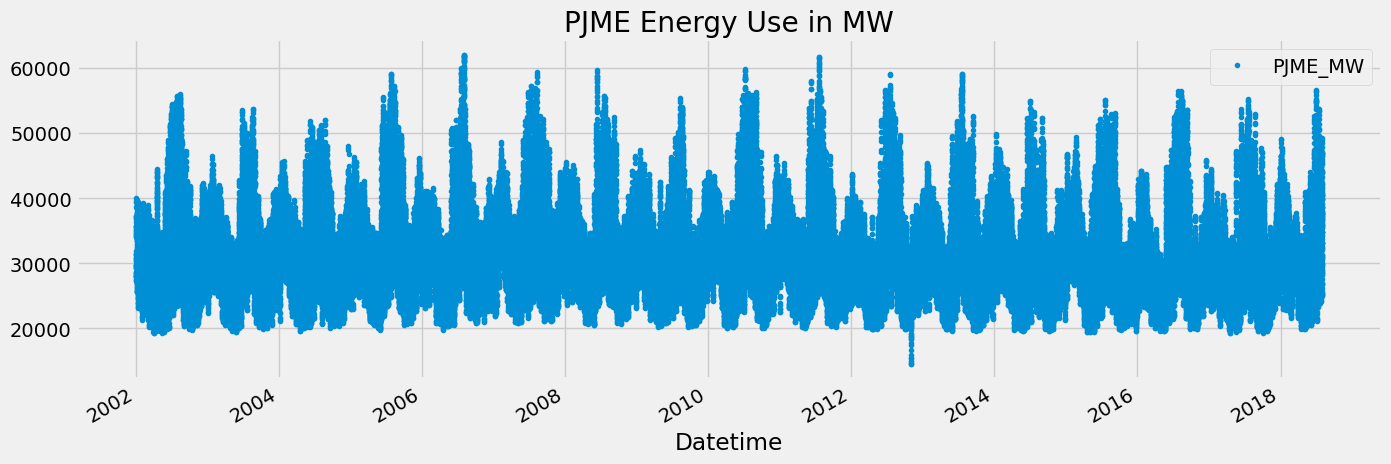

In [308]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

1. Outlier Analysis and Removal

<Axes: ylabel='Frequency'>

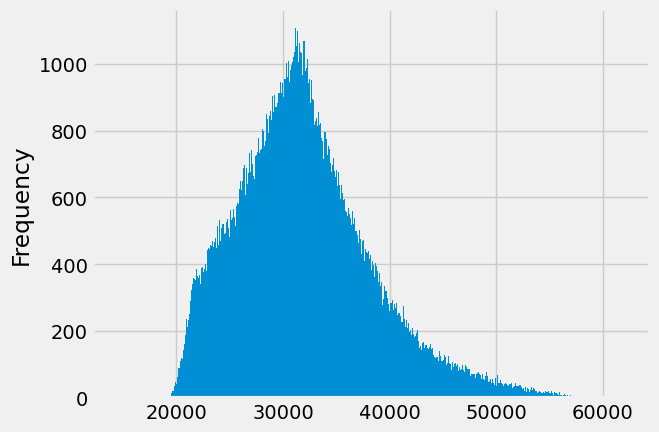

In [311]:
df['PJME_MW'].plot(kind='hist', bins=500)

<Axes: xlabel='Datetime'>

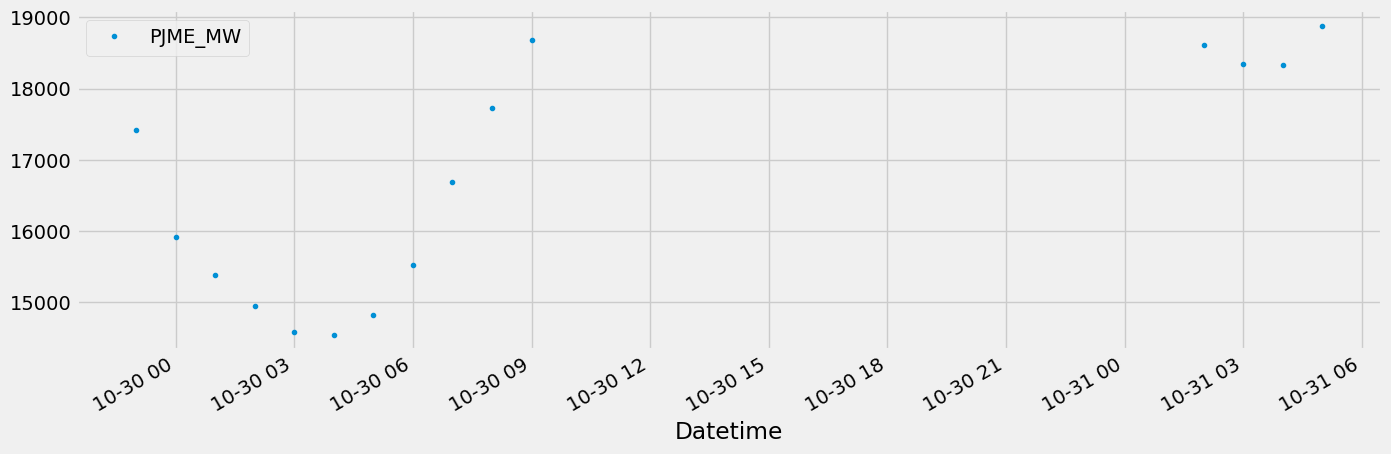

In [313]:
df.query('PJME_MW < 19_000').plot(figsize = (15,5), style ='.')

In [352]:
df = df.query('PJME_MW > 19_000').copy()

2. Train/Test Split

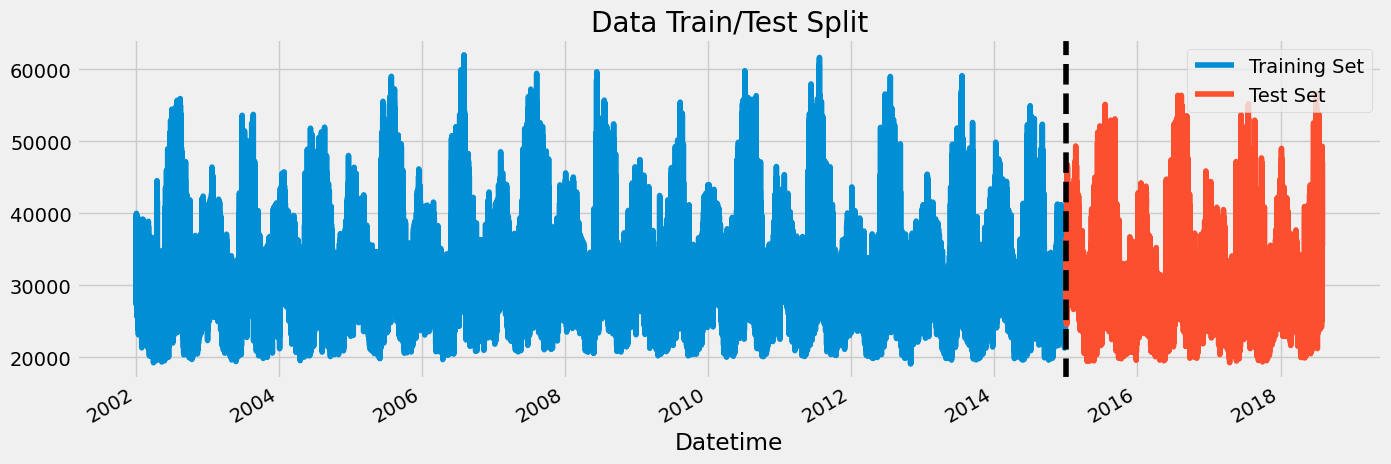

In [317]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

Time Series Cross Validation

In [319]:
from sklearn.model_selection import TimeSeriesSplit
#setting the object
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df= df.sort_index()

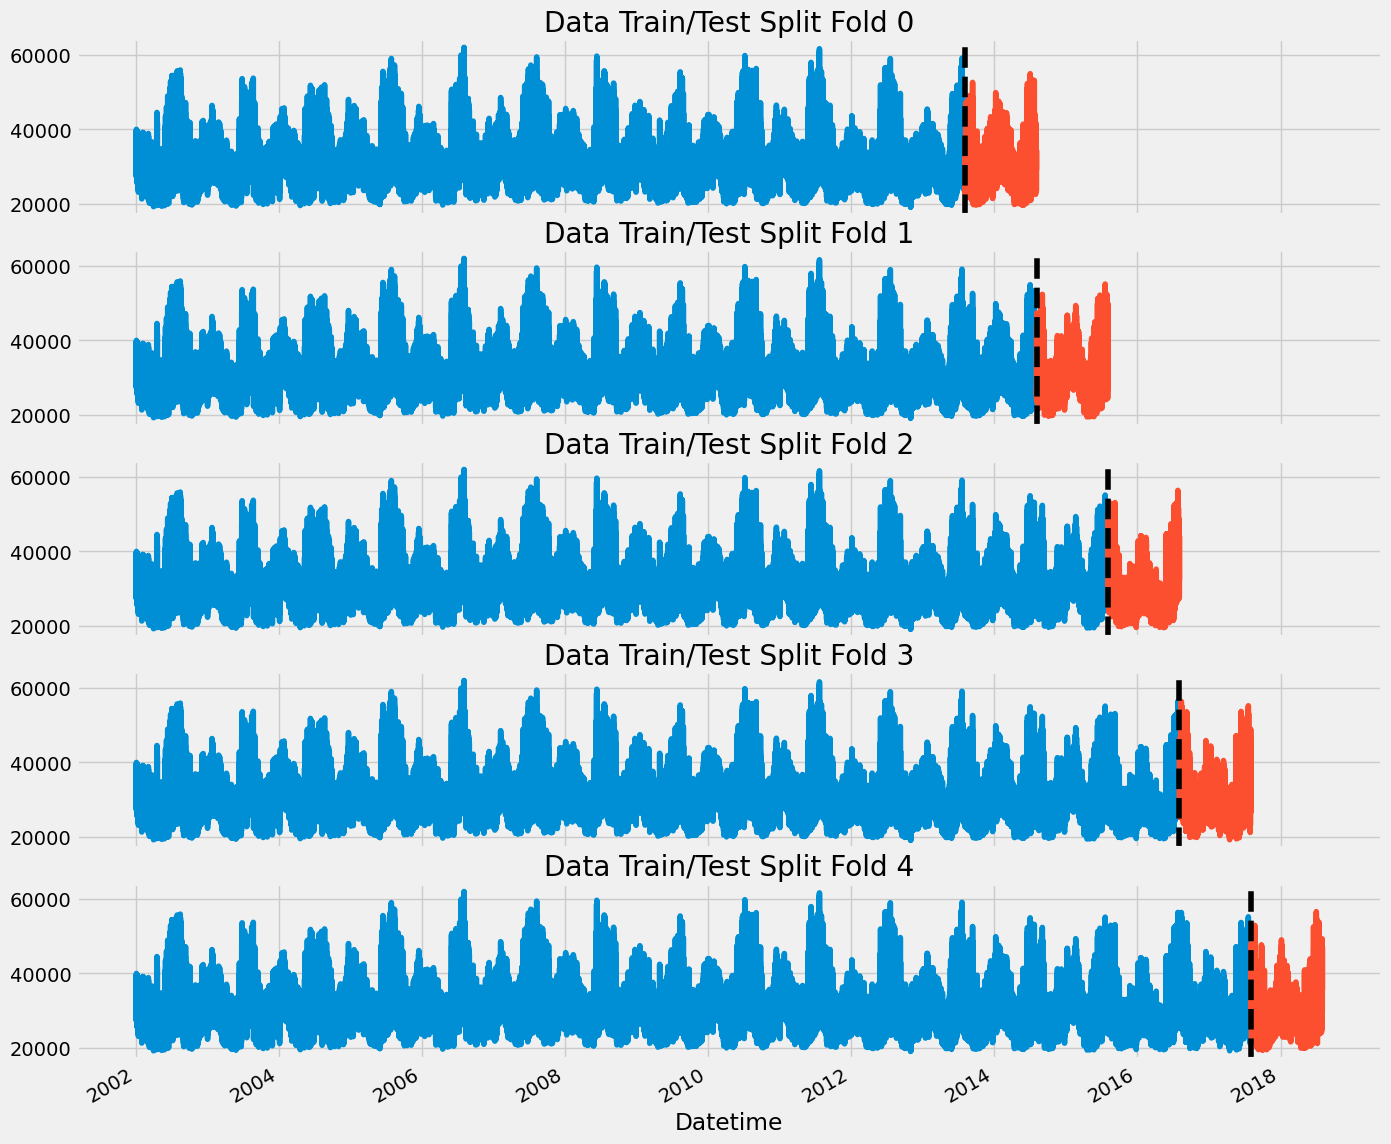

In [321]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):  
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold], 
                          label='Training Set', title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold], 
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold +=1

plt.show()


3. Forcasting Horizon Explained \
The forecast horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than three months) to long-term horizons (more than two years).

In [356]:
def create_features(df):
    """
    Create time series features based on the time series index
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df
df = create_features(df)

4. Lag Features \
    -What was the target(x) days in the past

In [358]:
target_map = df['PJME_MW'].to_dict()

In [360]:
def add_lags(df):
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [362]:
df = add_lags(df)

In [109]:
#Plot the lag features to check
#fig, axs = plt.subplots(figsize=(15, 15), sharex=True)
#df['PJME_MW'].plot(ax=axs, label='PJME_MW', style ='.', title='Original data')
#df['lag1'].plot(ax=axs, label='Lag 1', style ='.', title='Lag data')
#df['lag2'].plot(ax=axs, label='Lag 2', style ='.')
#df['lag3'].plot(ax=axs, label='Lag 3', style ='.')
#plt.show()

Train using Cross Validation

In [364]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:32732.49608	validation_1-rmse:31956.60163


C:\Users\rreng\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:09:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12532.64369	validation_1-rmse:11906.14134
[200]	validation_0-rmse:5747.92495	validation_1-rmse:5359.26490
[300]	validation_0-rmse:3872.48134	validation_1-rmse:3900.86965
[400]	validation_0-rmse:3434.23853	validation_1-rmse:3762.33705
[442]	validation_0-rmse:3369.34730	validation_1-rmse:3764.82810
[0]	validation_0-rmse:32672.16678	validation_1-rmse:32138.89241


C:\Users\rreng\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:09:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12513.65574	validation_1-rmse:12224.93373
[200]	validation_0-rmse:5753.34937	validation_1-rmse:5662.07107
[300]	validation_0-rmse:3902.71304	validation_1-rmse:3933.73076
[400]	validation_0-rmse:3476.90515	validation_1-rmse:3590.55005
[500]	validation_0-rmse:3353.72424	validation_1-rmse:3516.39915
[600]	validation_0-rmse:3297.94766	validation_1-rmse:3481.94003
[700]	validation_0-rmse:3258.48267	validation_1-rmse:3461.37383
[800]	validation_0-rmse:3221.51553	validation_1-rmse:3436.49603
[900]	validation_0-rmse:3190.11480	validation_1-rmse:3428.88699
[999]	validation_0-rmse:3166.16314	validation_1-rmse:3420.31309
[0]	validation_0-rmse:32631.20370	validation_1-rmse:31073.29733


C:\Users\rreng\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:09:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12499.28425	validation_1-rmse:11136.72805
[200]	validation_0-rmse:5750.81453	validation_1-rmse:4813.21239
[300]	validation_0-rmse:3917.04200	validation_1-rmse:3553.40541
[400]	validation_0-rmse:3494.55924	validation_1-rmse:3495.25153
[410]	validation_0-rmse:3476.66883	validation_1-rmse:3502.18342
[0]	validation_0-rmse:32528.44438	validation_1-rmse:31475.39670


C:\Users\rreng\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:09:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12462.30026	validation_1-rmse:12019.98579
[200]	validation_0-rmse:5738.32648	validation_1-rmse:5794.44193
[300]	validation_0-rmse:3915.76448	validation_1-rmse:4385.51180
[400]	validation_0-rmse:3499.03653	validation_1-rmse:4172.17589
[500]	validation_0-rmse:3382.83569	validation_1-rmse:4116.88298
[600]	validation_0-rmse:3324.23232	validation_1-rmse:4104.48851
[700]	validation_0-rmse:3281.46398	validation_1-rmse:4088.10832
[800]	validation_0-rmse:3249.57813	validation_1-rmse:4081.68309
[900]	validation_0-rmse:3223.05405	validation_1-rmse:4071.80961
[999]	validation_0-rmse:3198.63557	validation_1-rmse:4048.63496
[0]	validation_0-rmse:32462.05557	validation_1-rmse:31463.90500


C:\Users\rreng\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:09:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12445.92077	validation_1-rmse:11962.25620
[200]	validation_0-rmse:5752.09311	validation_1-rmse:5610.63120
[300]	validation_0-rmse:3953.21146	validation_1-rmse:4149.60103
[400]	validation_0-rmse:3541.03825	validation_1-rmse:3998.83825
[439]	validation_0-rmse:3482.71629	validation_1-rmse:4002.30426


In [366]:
print(f'Score acrosss folds {np.mean(scores):0.4f}')
print(f'Fold scores {scores}')

Score acrosss folds 3740.5258
Fold scores [3760.8277187583353, 3420.313091887879, 3477.9504020604863, 4048.634962892725, 3994.9029963460744]


5. Predicting the Future\
   -Retraining all data \
   -Predict the future create an empty dataframe \
   -Run those dates through the feature creation code

In [368]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = train[FEATURES]
y_all = train[TARGET]

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                        n_estimators=500,
                        early_stopping_rounds=50,
                        objective='reg:linear',
                        max_depth=3,
                        learning_rate=0.01)
reg.fit(X_all, y_all,
            eval_set=[(X_all, y_all)],
            verbose=100)


[0]	validation_0-rmse:32462.05557


C:\Users\rreng\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:09:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12445.92077
[200]	validation_0-rmse:5752.09311
[300]	validation_0-rmse:3953.21146
[400]	validation_0-rmse:3541.03825
[499]	validation_0-rmse:3429.89481


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [255]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [372]:
# Create Feature
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [374]:
future_w_features = df_and_future.query('isFuture').copy()

Predict the Future

<Axes: title={'center': 'Future Prediction'}>

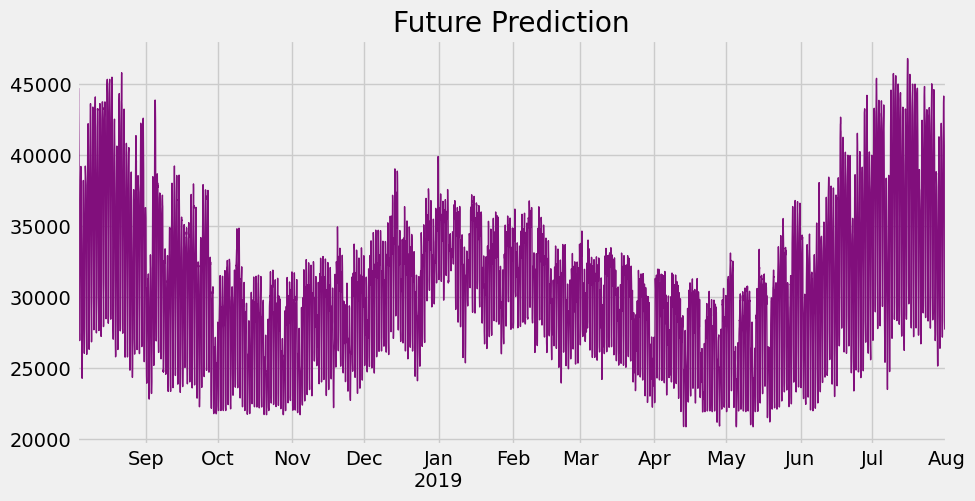

In [287]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize = (10,5), 
                               color = color_pal[5], 
                               ms=1, 
                               lw=1, 
                               title = 'Future Prediction')

Saving Model for Later\
Note: If you don't retrain the model every time we predict using new day or hour

In [275]:
#Save Model 
reg.save_model('model.json')

In [283]:
!ls -lh

'ls' is not recognized as an internal or external command,
operable program or batch file.


<Axes: title={'center': 'Future Prediction'}>

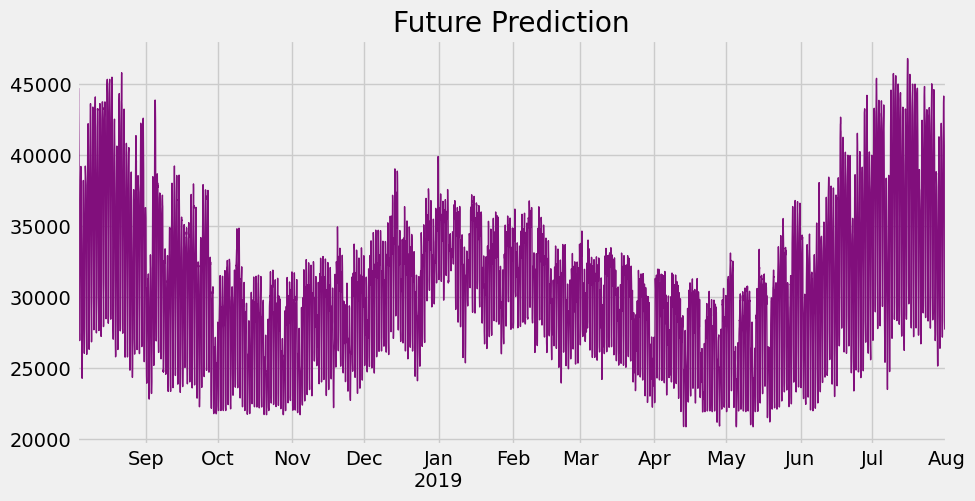

In [289]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize = (10,5), 
                               color = color_pal[5], 
                               ms=1, 
                               lw=1, 
                               title = 'Future Prediction')